# Rasterio plotting of Landsat-8 and Sentinel-2 scenes

Plotting Landsat-8 and Sentinel-2 scenes with [rasterio]( https://rasterio.readthedocs.io/en/latest/topics/plotting.html).

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.plot import show
import requests
from skimage import exposure

In [2]:
%matplotlib inline

## Download and read bands

In [3]:
landsat_url_suffixes = {'red': 'B4', 'green': 'B3', 'blue': 'B2', 'qa': 'BQA'}
landsat_url_prefix = ('http://landsat-pds.s3.amazonaws.com/c1/L8/206/021/LC08_L1TP_206021_20170325_20170329_01_T1/LC08_L1TP_206021_20170325_20170329_01_T1_')
landsat_urls = {k: '{}{}.TIF'.format(landsat_url_prefix, v) for k, v in landsat_url_suffixes.items()}

sentinel_url_suffixes = {'red': 'B04', 'green': 'B03', 'blue': 'B02'}
sentinel_url_prefix = 'https://sentinel-s2-l1c.s3.amazonaws.com/tiles/30/V/UH/2018/2/25/0/'
sentinel_urls = {k: '{}{}.jp2'.format(sentinel_url_prefix, v) for k, v in sentinel_url_suffixes.items()}

In [4]:
def get_bands(band_urls, data_path='data', file_format='tif'):
    """Download and cache spectral bands of a satellite image
    
    Parameters
    ----------
    band_urls : dict
        URLs of individual bands: {<band_name>: <url>}
    data_path : string (optional)
        Location to save the data
    file_format : string (optional)
        File format of band

    Returns
    -------
    bands : dict
        Band arrays and the profile
        
    """
    if not os.path.exists(data_path):
        os.makedirs(data_path)

    bands = {}

    for k, v in band_urls.items():
        print(os.path.basename(v))

        band_path = os.path.join(data_path, '{}.{}'.format(k, file_format))
        if not os.path.exists(band_path):
            print('Downloading...\n')
            r = requests.get(v)
            with open(band_path, 'wb') as f:
                f.write(r.content)
        else:
            print('Already downloaded...\n')

        with rasterio.open(band_path) as src:
            bands[k] = src.read(1)
            if 'profile' not in bands:
                bands['profile'] = src.profile

    return bands

In [5]:
landsat_bands = get_bands(landsat_urls, data_path='data/landsat', file_format='tif')
sentinel_bands = get_bands(sentinel_urls, data_path='data/sentinel', file_format='jp2')

LC08_L1TP_206021_20170325_20170329_01_T1_B4.TIF
Downloading...

LC08_L1TP_206021_20170325_20170329_01_T1_B3.TIF
Downloading...

LC08_L1TP_206021_20170325_20170329_01_T1_B2.TIF
Downloading...

LC08_L1TP_206021_20170325_20170329_01_T1_BQA.TIF
Downloading...

B04.jp2
Downloading...

B03.jp2
Downloading...

B02.jp2
Downloading...



## Plot individual bands

Use `rasterio.plot.show()` to plot individual bands. The `transform` argument changes the image extent to the spatial bounds of the image.

In [6]:
def plot_rgb_bands(bands):
    fig, (axr, axg, axb) = plt.subplots(1, 3, figsize=(21, 7))
    transform = bands['profile']['transform']
    show(bands['red'], ax=axr, cmap='Reds', title='Red band', transform=transform, vmax=np.percentile(bands['red'], 95))
    show(bands['green'], ax=axg, cmap='Greens', title='Green band', transform=transform, vmax=np.percentile(bands['red'], 95))
    show(bands['blue'], ax=axb, cmap='Blues', title='Blue band', transform=transform, vmax=np.percentile(bands['red'], 95))
    plt.show()

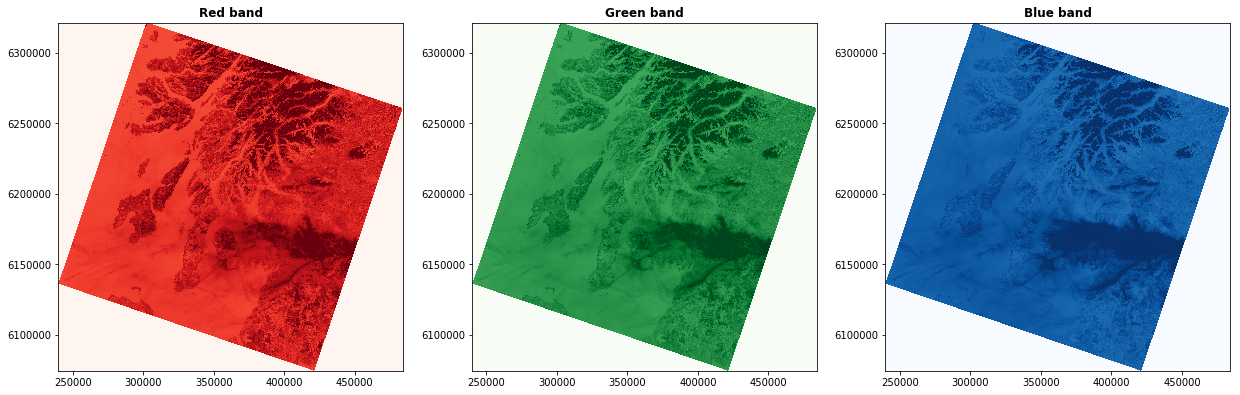

In [7]:
plot_rgb_bands(landsat_bands)

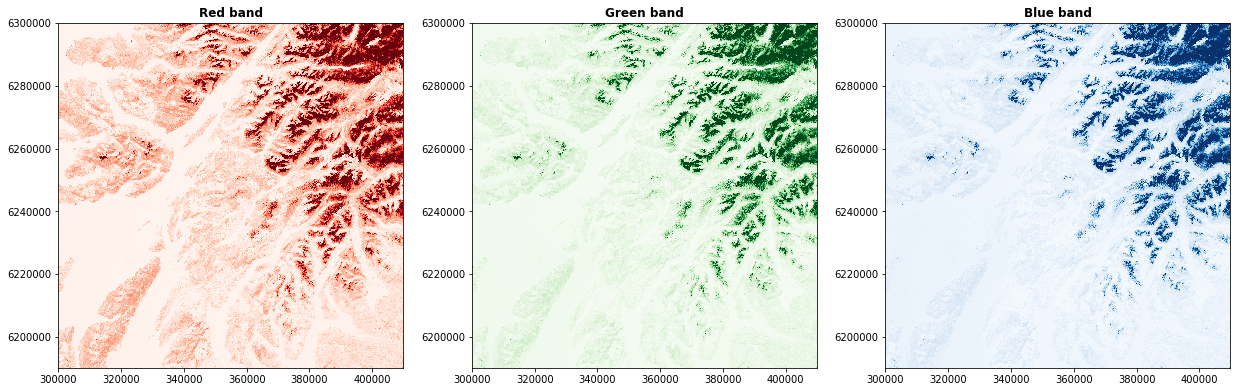

In [8]:
plot_rgb_bands(sentinel_bands)

## Create RGB stack

Modify the RGB bands through rescaling or equalization and create a stack.

In [9]:
def create_rgb_stack(bands, method='rescaling', percentile=2, clip_limit=0.03):
    """Create RGB stack from RGB bands

    Parameters
    ----------
    bands : dict
        Band arrays in {<band_name>: <array>} format, including 'red',
        'green', 'blue', and 'qa' (optional) keys
    method : string (optional)
        Method for modifying the band intensities. 'rescaling' stretches
        or shrinks the intensity range. 'clahe' applies Contrast Limited
        Adaptive Histogram Equalization, which is an algorithm for
        local contrast enhancement.
    percentile : int (optional)
        Shorthand for percentile range to compute (from percentile to
        100 - percentile) for intensity rescaling. Required when
        method='rescaling'.
    clip_limit : float (optional)
        Clipping limit. Required when method='clahe'.

    Returns
    -------
    ndarray
        RGB array (shape=(3, height, width), dtype='uint8')

    """
    modified_bands = []
    for band in [bands['red'], bands['green'], bands['blue']]:

        if method == 'rescaling':

            # Calculate percentiles, excluding fill pixels
            try:
                fill_mask = bands['qa'] == 1
                masked_band = np.ma.masked_where(fill_mask, band)
                masked_band = np.ma.filled(masked_band.astype('float'), np.nan)
            except KeyError:
                masked_band = band
            vmin, vmax = np.nanpercentile(masked_band,
                                          (percentile, 100 - percentile))

            # Rescale to percentile range
            modified_band = exposure.rescale_intensity(
                band, in_range=(vmin, vmax), out_range='uint8')
            modified_band = modified_band.astype(np.uint8)

        elif method == 'clahe':

            # Apply histogram equalization
            modified_band = exposure.equalize_adapthist(
                band, clip_limit=clip_limit)
            modified_band = (modified_band * 255).astype(np.uint8)

        modified_bands.append(modified_band)

    return np.stack(modified_bands)

In [10]:
landsat_bands['rgb'] = create_rgb_stack(landsat_bands, method='clahe')
sentinel_bands['rgb'] = create_rgb_stack(sentinel_bands, method='clahe')

## Plot RGB image

In [11]:
def plot_rgb_band_combination(bands):
    plt.figure(figsize=(10, 10))
    show(bands['rgb'], transform=bands['profile']['transform'])

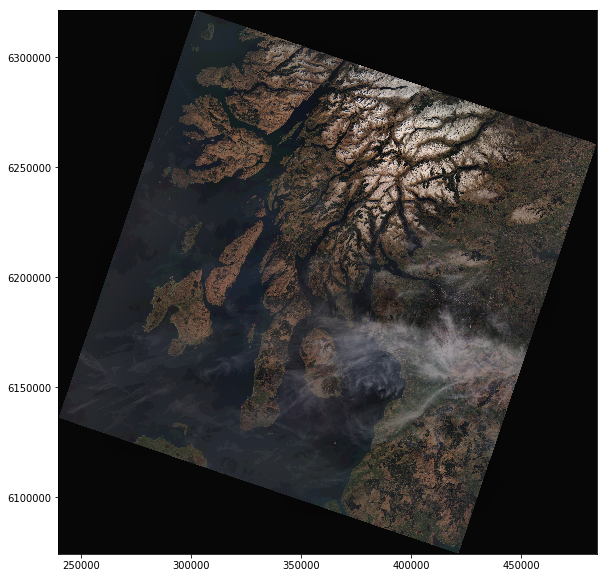

In [12]:
plot_rgb_band_combination(landsat_bands)

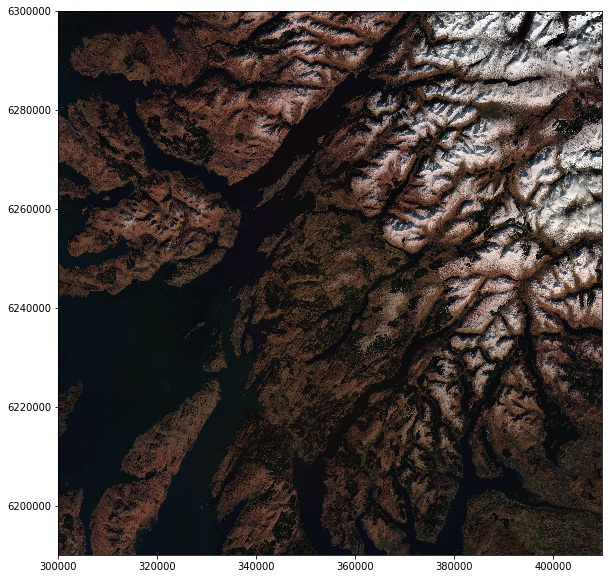

In [13]:
plot_rgb_band_combination(sentinel_bands)

## Write RGB image

Write the RGB stack as GeoTIFF and set 'RGB' color interpretation.

In [14]:
def write_rgb_band_combination(bands, data_path='data'):
    profile = bands['profile']
    profile.update(driver='GTiff', dtype=rasterio.uint8, count=3, photometric='RGB')
    rgb_path = os.path.join(data_path, 'rgb.tif')
    with rasterio.open(rgb_path, 'w', **profile) as dst:
        for i, band in enumerate(bands['rgb']):
            dst.write_band(i + 1, band)

In [15]:
write_rgb_band_combination(landsat_bands, data_path='data/landsat')
write_rgb_band_combination(sentinel_bands, data_path='data/sentinel')